In [4]:
#----- imports --------
import tqdm
import torch
import wandb
import os
import tokenizers
from torch.utils.data import Dataset




device= 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
assert device == 'cuda', "This notebook is not optimized for CPU"

config = {
    "learning_rate": 1e-3,
    "eval_interval": 300,
    "max_iters": 60000, 
    "H": 32, # hidden dimension size
    "B": 64,
    "T": 256,
    "C": 256,
    "feedforward_factor": 3,
    "n_heads": 8,
    "dropout": 0.0,
    "l2_penalty": 0.0,
    "n_layers": 12,
    "tokenizer_vocab_size": 2**13,
    "git_hash": os.popen("git rev-parse HEAD").read().strip()
}

# initial
for k,v in config.items():
    locals ()[k] = v


#wandb.init(
#    project = "tinystories",
#    config = config,
#)

In [5]:

with open('TinyStoriesV2-GPT4-valid.txt', 'r', encoding='utf-8') as f:
    stories = f.read().split('<|endoftext|>')



In [6]:
stories[-1]

'\nOnce upon a time, in a hot and sandy land, there was a little camel named Cally. Cally lived near an oasis, a place with water and trees. She loved to play there with her friends.\nOne day, a fierce lion came to the oasis. He was very big and scary. The lion roared and demanded, "Give me all your food!" Cally and her friends were scared, but they wanted to save their oasis.\nCally had an idea. She told her friends to make a big, loud noise. They stomped their feet and yelled together. The lion was scared of the noise and ran away. Cally and her friends saved the oasis and were very happy.'

In [8]:
# paths = ['tinystories-train.txt']
# tokenizer = tokenizers.ByteLevelBPETokenizer()

# tokenizer.train(files=paths, vocab_size=tokenizer_vocab_size, min_frequency=2)

# tokenizer.save_model('.', 'tiny-stories-bpe')



# enc = tokenizer.encode("She sells sea shells by the sea shore!")
# tokenizer.decode(enc.ids)



'She sells sea shells by the sea shore!'

In [7]:
tokenizer = tokenizers.ByteLevelBPETokenizer(
    "./tiny-stories-bpe-vocab.json", 
    "./tiny-stories-bpe-merges.txt"
)


In [8]:

def encode(text):
    return torch.tensor(tokenizer.encode(text).ids, dtype=torch.int64)
def decode(encoded_text):
    return tokenizer.decode(encoded_text.tolist())

from tqdm import tqdm



hello_encoded = encode("hello")
print(hello_encoded)
print(decode(hello_encoded))
vocab_size = tokenizer.get_vocab_size()
print("vocab size: ", vocab_size)

tensor([6132], device='cuda:0')
hello
vocab size:  8192


In [9]:
stories_encoded = [encode(story) for story in stories]

# save stores_encoded to a file
torch.save(stories_encoded, 'stories_encoded.pt')

In [10]:
class Bin:
    def __init__(self, bin_capacity):
        self.remaining_capacity = bin_capacity
        self.items = []
    def add_item(self, item):
        self.items.append(item)
        self.remaining_capacity -= item
    def fits(self, item):
        return self.remaining_capacity >= item

    def __repr__(self):
        return f'Bin(remaining_capacity={self.remaining_capacity}, items={self.items})'

def put_in_bin(bins, bin_capacity, item):
    for bin in bins:
        if bin.fits(item):
            bin.add_item(item)
            break
    else:
        newbin = Bin(bin_capacity)
        newbin.add_item(item)
        bins.append(newbin)



def first_fit_sequence_packing(list_of_lengths, max_length):
    list_of_lengths.sort(reverse=True)
    bins = []
    for length in list_of_lengths:
        put_in_bin(bins, max_length, length)
    return bins



bins = first_fit_sequence_packing([6, 2, 1, 4], 5)
for bin in bins:
    print(bin)


Bin(remaining_capacity=-1, items=[6])
Bin(remaining_capacity=0, items=[4, 1])
Bin(remaining_capacity=3, items=[2])


In [11]:
encoded_story_lengths = [len(story) for story in stories_encoded]

context_length = 512
bins = first_fit_sequence_packing(encoded_story_lengths, context_length)
print("number of bins", len(bins))

total_remaining_capacity = 0
for bin in bins:
    if bin.remaining_capacity > 0:
        total_remaining_capacity += bin.remaining_capacity

number of bins 11296


In [13]:
total_remaining_capacity/len(bins)

26.569670679886684

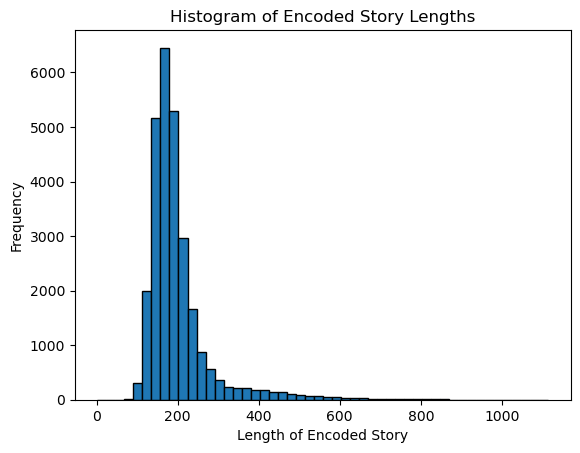

In [23]:
import matplotlib.pyplot as plt

# Calculate the length of each encoded story
encoded_story_lengths = [len(story) for story in stories_encoded]

# Plot the histogram
plt.hist(encoded_story_lengths, bins=50, edgecolor='black')
plt.title('Histogram of Encoded Story Lengths')

plt.xlabel('Length of Encoded Story')
plt.ylabel('Frequency')
plt.show()

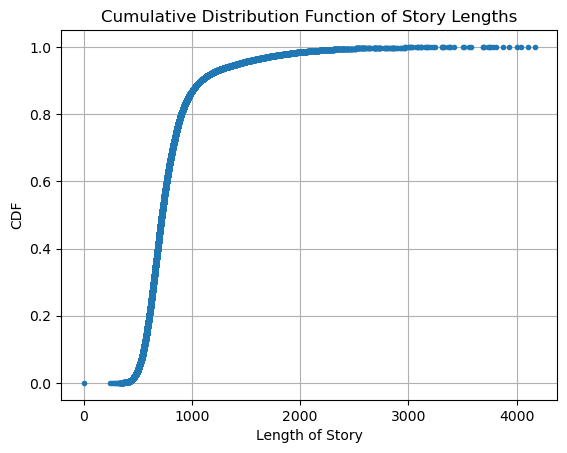

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the length of each story
story_lengths = [len(story) for story in stories]

# Sort the story lengths
sorted_lengths = np.sort(story_lengths)

# Calculate the cumulative distribution
cdf = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)

# Plot the CDF
plt.plot(sorted_lengths, cdf, marker='.', linestyle='none')
plt.title('Cumulative Distribution Function of Story Lengths')
plt.xlabel('Length of Story')
plt.ylabel('CDF')
plt.grid(True)
plt.show()

In [7]:
total_chars = 0
total_tokens = 0
for story in stories[:100]:
    total_chars += len(story)
    total_tokens += len(encode(story))

print(f"total characters: {total_chars}, total tokens: {total_tokens}")
print(f"characters per token: {total_chars / total_tokens}")


total characters: 81562, total tokens: 20461
characters per token: 3.986217682420214


In [15]:
class TinyStoriesDataset(Dataset):
    def __init__(self, stories_encoded):
        self.stories_encoded = stories_encoded

    def __len__(self):
        return len(self.stories_encoded)

    def __getitem__(self, idx):
        return self.stories_encoded[idx]

In [17]:
tinystoriesdataset = TinyStoriesDataset(stories_encoded)
decode(tinystoriesdataset[0])


'u don\'t have to be scared of the loud dog, I\'ll protect you". The mole felt so safe with the little girl. She was very kind and the mole soon came to trust her. He leaned against her and she kept him safe. The mole had found his best friend.\n'

In [ ]:
tinystoriesdataloader = DataLoader(tinystoriesdataset, batch_size=B, shuffle=True)


In [10]:
# load data from tiny-stories-train.pt
data = torch.load('tiny-stories-train.pt', map_location='cuda')


In [11]:
n = int(0.9*len(data))

train_data = data[:n]
val_data = data[n:]

In [12]:
train_data.size()

torch.Size([421949048])

In [13]:
train_data[:T+1]

tensor([  83, 3206,  198,    1,  421,  356,   11,  258,  397,  447,  501,  364,
         596,  258, 3736,  316,  309,  759,   13,  313,  704,  304,  282, 2966,
         265,  359,  342,  304,  788,  304,  282, 2120,   13,  364,  445,  265,
         949,  262, 3736,  342,  309,  365,   11,  350,  338,  461, 5198,  258,
        2228,  345,  309, 2500,   13,  198,  198,  343,  469,  265,  309,  365,
         264,  327,   11,  329,  771,   11,  335,  596,  741, 3736,   13, 1282,
         346,  949,  304,  342,  519,  264, 5198,  652, 2500,  478,  866,  365,
         499,  264,  327,   11,  329,  832,   11,  364,   11,  363,  472,  949,
         262, 3736,  264, 1306,  627, 2500,  416,  198,  198, 4625,   11,  362,
        1656,  262, 3736,  264, 7930,  262, 2228,  345,  364,  371, 2500,   13,
         410,  282,  385, 2966,  366,  449,  788,  362,  430, 2502,  264, 1762,
         757,  573,   13, 1453,  362, 1444,   11,  364,  858,  309,  365,  366,
        2502,  262, 3736,  264, 5150,  3

In [14]:
decode(train_data[:T+1].cpu().numpy())

'text\n"One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, ""Mom, I found this needle. Can you share it with me and sew my shirt?"" Her mom smiled and said, ""Yes, Lily, we can share the needle and fix your shirt.""\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together."\n"Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.\n\nOne day, Beep was driving in the park when he saw a big tree. The tree had many leave

In [15]:
x = train_data[:T]
y = train_data[1:T+1]
for t in range(T):
    context = x[:t+1]
    target = y[t]
    # print("when we see the text", context, "we predict the next character is", target)

In [16]:
torch.manual_seed(1337)

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, data.size(0) - T, (B,)) # 4 random locations we can sample from
    x = torch.stack([data[i:i+T] for i in ix]) # random sequences
    y = torch.stack([data[i+1:i+T+1] for i in ix]) # next character for each random sequence

    return x, y

xb, yb = get_batch('train')

for b in range(B):
    for t in range(T): # for each of the characters in the sample
        context = xb[b, :t+1]
        target = yb[b, t]


In [10]:

import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)


class Head(nn.Module):
    '''One Head of self-attention'''
    def __init__(self, H):
        super().__init__()
        self.query = nn.Linear(C, H, bias=False)
        self.key = nn.Linear(C, H, bias=False)
        self.value = nn.Linear(C, H, bias=False)
        # self.output = nn.Linear(H, C, bias=False) # output matrix
        self.register_buffer('tril', torch.tril(torch.ones(T, T)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Query and Key matrices for the attention mechanism
        # x: 8 tokens
        # Q: 16 tall (arbitrary), 32 long channels
        # K: 16 tall (arbitrary), 32 long channels

        query_vectors = self.query(x)
        key_vectors = self.key(x)


        # Attention masking(so we can't look into the past):

        tril = self.tril
        wei = torch.zeros(T, T) 
        wei = wei.masked_fill(tril == 0, float('-inf')) # set the upper triangular to -inf
        # xbow = wei @ x # apply the mask to the input, bag of words because simple avg.

        # multiply the two to get the attention weights
        attention_pattern = query_vectors @ key_vectors.transpose(-2, -1) # T, T
        attention_pattern = attention_pattern / (H ** 0.5) # scale the attention pattern for numerical stability
        attention_weights = F.softmax(attention_pattern + wei, dim=-1) # T, T (the row dimension is the query)
        attention_weights = self.dropout(attention_weights)

        value_vectors = self.value(x) # the direction we should go in the embedding space for each token (ie more blue) T, H

        # apply the attention weights to the value vectors
        context = attention_weights @ value_vectors # T, H

        # project back into original space from value space
        # return self.output(context)
        return context

x = torch.randn(B,T,C)
head = Head(H)
# head(x)

In [11]:
class MultiHeadAttention(nn.Module):
    '''Multiple heads of self-attention'''
    def __init__(self, H, C, n_heads): # H is head embedding space size, n_heads is number of heads
        super().__init__()
        self.heads = nn.ModuleList([Head(H) for _ in range(n_heads)])
        self.combine_heads = nn.Linear(H*n_heads, C)
        self.dropout = nn.Dropout(dropout)


    def forward(self,x):
        x = torch.cat([head(x) for head in self.heads], dim=-1)
        x = self.combine_heads(x)  # T, C
        return self.dropout(x)

In [12]:
head = MultiHeadAttention(H, C, n_heads)
head.heads[0].forward(x).shape


torch.Size([64, 256, 32])

In [13]:
class FeedForward(nn.Module):
    '''Feed-forward neural network'''
    def __init__(self, C):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(C, C * feedforward_factor),
            nn.ReLU(),
            nn.Linear(C * feedforward_factor, C),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

In [14]:
class LayerNorm(nn.Module):
    '''Layer normalization'''
    def __init__(self, C, use_affine=True):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(C)) if use_affine else None
        self.beta = nn.Parameter(torch.zeros(C)) if use_affine else None

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        if self.gamma is not None and self.beta is not None:
            return self.gamma * (x - mean) / (std + 1e-6) + self.beta
        else:
            return (x - mean) / (std + 1e-6)

In [15]:
class Block(nn.Module):
    '''Transformer block'''
    def __init__(self, H, C, n_heads):
        super().__init__()
        self.attention = MultiHeadAttention(H, C, n_heads)
        self.ff = FeedForward(C)
        self.norm1 = LayerNorm(C, use_affine=True)
        self.norm2 = LayerNorm(C, use_affine=True)

    def forward(self, x):
        x = x + self.attention(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x

In [50]:
class GPT(nn.Module):

    def __init__(self, n_layers):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, C) 
        self.position_embedding_table = nn.Embedding(T, C)
        self.lm_head = nn.Linear(C, vocab_size)
        self.layers = nn.ModuleList([Block(H, C, n_heads) for _ in range(n_layers)])
        self.block = nn.ModuleList([Block(H, C, n_heads)])
    
    def forward(self, idx, targets=None):
        B, T = idx.shape
        token_emb = self.token_embedding_table(idx) # batch_dim, sequence_dim, embedding_dim
        pos_emb = self.position_embedding_table(torch.arange(T))
        x = token_emb + pos_emb # token identities and positions contained

        for layer in self.layers:
            x = layer(x)

        logits = self.lm_head(x) # batch_dim, sequence_dim, vocab_size

        batch_dim, sequence_dim, embedding_dim = logits.size()

        # loss = F.cross_entropy(logits, targets) this won't work because we need 1d logits and 1d targets
        # one-hot-vectors are a line in the x-dimension, so the shape of shape of the logits should be (-1, vocab_size).

        if targets is None:
            return logits, None
        else:
            # a list of all the predictions, reguardles of batch.
            # xdim: probabilities of each character in the vocab (embedding_dim=vocab_size)
            # ydim: all predictions for all batches flattened (batch_dim*sequence_dim)
            logits_loss_view = logits.view(-1, vocab_size) 
            # targets loss view
            # xdim: all targets for all batches flattened (batch_dim*sequence_dim)
            # so this would be like, [1,4,5,1,2,3, ...]
            # where each number is the correct next index of the one hot vector
            targets_loss_view = targets.view(-1)
            loss = F.cross_entropy(logits_loss_view, targets_loss_view)
            return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx[:,-T:])
            # get the predictions of the last token
            last_token_logits = logits[:, -1, :] # all batches, last token, all probabilities
            # softmax to get probabilities
            probabilities = F.softmax(last_token_logits, dim=-1)
            # sample from the probabilities
            next_token = torch.multinomial(probabilities, num_samples=1)
            # add the new token to the idx tensor
            idx = torch.cat((idx, next_token), dim=1)
        return idx
    def prompt_model(self, prompt, max_new_tokens, temperature=0.5):
        autoregressive_seq = encode(prompt)
        for _ in range(max_new_tokens):
            prediction_index = len(autoregressive_seq)-1

            model_input = torch.tensor(autoregressive_seq)
            
            while model_input.shape[0] < T:
                pad_token = torch.tensor(encode("\n"))
                model_input = torch.cat((model_input, pad_token), dim=0)

            model_input
            model_input = model_input.unsqueeze(0)

            logits, loss = model(model_input)
            prediction_token = logits[:, prediction_index, :] / temperature
            probabilities = F.softmax(prediction_token, dim=-1)
            next_token = torch.multinomial(probabilities, num_samples=1)
            next_token = next_token.item()

            autoregressive_seq.append(next_token)
        # get the autoregressive sequence
        return decode(autoregressive_seq)



    

model = GPT(n_layers)
logits, loss = model(xb, yb)
print(logits.shape)
print(loss)




test_idx = torch.zeros(1, T).long()
model.forward(idx=test_idx)
# decode(model.generate(idx=test_idx, max_new_tokens=100)[0].tolist())

NameError: name 'xb' is not defined

In [17]:
model

GPT(
  (token_embedding_table): Embedding(8192, 256)
  (position_embedding_table): Embedding(256, 256)
  (lm_head): Linear(in_features=256, out_features=8192, bias=True)
  (layers): ModuleList(
    (0-11): 12 x Block(
      (attention): MultiHeadAttention(
        (heads): ModuleList(
          (0-7): 8 x Head(
            (query): Linear(in_features=256, out_features=32, bias=False)
            (key): Linear(in_features=256, out_features=32, bias=False)
            (value): Linear(in_features=256, out_features=32, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (combine_heads): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=256, out_features=768, bias=True)
          (1): ReLU()
          (2): Linear(in_features=768, out_features=256, bias=True)
          (3): Dropout(p=0.0, inplace=False)
  

In [25]:
# get the number of parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("number of parameters in the model: ", count_parameters(model))

number of parameters in the model:  12817664


In [26]:
data.shape

torch.Size([468832276])

In [27]:
# logits, loss = self(idx[:,-T:])

idx = torch.zeros(1, 1).long()
idx[:,-T:]

tensor([[0]], device='cuda:0')

In [28]:
model.token_embedding_table.weight.device

device(type='cuda', index=0)

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



In [30]:
eval_iters = 10
eval_interval = 300
@torch.no_grad()
def estimate_loss(is_last=False):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        real_iters = eval_iters
        if is_last and split == 'val':  # increase last eval to mitigate noise
            real_iters *= 10 
        losses = torch.zeros(real_iters)
        for k in range(real_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean() / chars_per_token
    model.train()
    return out
    

In [31]:
# get the number of parameters
n_params = sum(p.numel() for p in model.parameters())
parameter_to_data_ratio = n_params / len(train_data)
print(f"{parameter_to_data_ratio=}")

parameters = []
for name, param in model.named_parameters():
    parameters.append({"name": name, "params": param.numel()})

# sort parameters by size
sorted_parameters = sorted(parameters, key=lambda x: x["params"], reverse=True)
for p in sorted_parameters:
    print(f"{p['name']}: {p['params']}")

parameter_to_data_ratio=0.03037727910693141
token_embedding_table.weight: 2097152
lm_head.weight: 2097152
layers.0.ff.net.0.weight: 196608
layers.0.ff.net.2.weight: 196608
layers.1.ff.net.0.weight: 196608
layers.1.ff.net.2.weight: 196608
layers.2.ff.net.0.weight: 196608
layers.2.ff.net.2.weight: 196608
layers.3.ff.net.0.weight: 196608
layers.3.ff.net.2.weight: 196608
layers.4.ff.net.0.weight: 196608
layers.4.ff.net.2.weight: 196608
layers.5.ff.net.0.weight: 196608
layers.5.ff.net.2.weight: 196608
layers.6.ff.net.0.weight: 196608
layers.6.ff.net.2.weight: 196608
layers.7.ff.net.0.weight: 196608
layers.7.ff.net.2.weight: 196608
layers.8.ff.net.0.weight: 196608
layers.8.ff.net.2.weight: 196608
layers.9.ff.net.0.weight: 196608
layers.9.ff.net.2.weight: 196608
layers.10.ff.net.0.weight: 196608
layers.10.ff.net.2.weight: 196608
layers.11.ff.net.0.weight: 196608
layers.11.ff.net.2.weight: 196608
block.0.ff.net.0.weight: 196608
block.0.ff.net.2.weight: 196608
position_embedding_table.weight: 6

In [37]:
import tqdm
num_params = sum([p.numel() for p in model.parameters()])

for steps in tqdm.tqdm(range(max_iters)):
    xb, yb = get_batch('train')
    # loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    # l2 regularization
    l2 = sum(p.pow(2).sum() for p in model.parameters()) / num_params
    loss = loss + l2 * l2_penalty

    loss.backward()
    optimizer.step()
    if steps % eval_interval == 0:
        losses = estimate_loss()
        # wandb.log({"tIain": losses['train'].item(), "val": losses['val'].item(), "l2":l2})
        print({"tIain": losses['train'].item(), "val": losses['val'].item(), "l2":l2})

losses = estimate_loss(is_last=True)
wandb.log({"train": losses['train'].item(), "val": losses['val'].item()})
wandb.finish()


  0%|          | 2/60000 [00:00<6:06:36,  2.73it/s] 

{'tIain': 0.37523791193962097, 'val': 0.3870525062084198, 'l2': tensor(0.2279, device='cuda:0', grad_fn=<DivBackward0>)}


  1%|          | 302/60000 [00:35<4:06:06,  4.04it/s]

{'tIain': 0.38546469807624817, 'val': 0.38315415382385254, 'l2': tensor(0.2282, device='cuda:0', grad_fn=<DivBackward0>)}


  1%|          | 602/60000 [01:11<3:58:11,  4.16it/s]

{'tIain': 0.38080012798309326, 'val': 0.3887944221496582, 'l2': tensor(0.2284, device='cuda:0', grad_fn=<DivBackward0>)}


  2%|▏         | 902/60000 [01:46<3:59:02,  4.12it/s]

{'tIain': 0.3815082609653473, 'val': 0.38819020986557007, 'l2': tensor(0.2287, device='cuda:0', grad_fn=<DivBackward0>)}


  2%|▏         | 1202/60000 [02:21<3:54:00,  4.19it/s]

{'tIain': 0.38699987530708313, 'val': 0.3811870515346527, 'l2': tensor(0.2290, device='cuda:0', grad_fn=<DivBackward0>)}


  3%|▎         | 1502/60000 [02:57<3:53:55,  4.17it/s]

{'tIain': 0.3874744474887848, 'val': 0.37942078709602356, 'l2': tensor(0.2292, device='cuda:0', grad_fn=<DivBackward0>)}


  3%|▎         | 1802/60000 [03:32<3:56:17,  4.11it/s]

{'tIain': 0.37514081597328186, 'val': 0.38777804374694824, 'l2': tensor(0.2295, device='cuda:0', grad_fn=<DivBackward0>)}


  4%|▎         | 2102/60000 [04:07<3:48:53,  4.22it/s]

{'tIain': 0.38220518827438354, 'val': 0.38456523418426514, 'l2': tensor(0.2297, device='cuda:0', grad_fn=<DivBackward0>)}


  4%|▍         | 2402/60000 [04:43<3:49:41,  4.18it/s]

{'tIain': 0.38074561953544617, 'val': 0.3859330713748932, 'l2': tensor(0.2300, device='cuda:0', grad_fn=<DivBackward0>)}


  5%|▍         | 2702/60000 [05:18<3:47:45,  4.19it/s]

{'tIain': 0.37715062499046326, 'val': 0.38477545976638794, 'l2': tensor(0.2303, device='cuda:0', grad_fn=<DivBackward0>)}


  5%|▌         | 3002/60000 [05:53<3:47:52,  4.17it/s]

{'tIain': 0.3810678720474243, 'val': 0.386946439743042, 'l2': tensor(0.2305, device='cuda:0', grad_fn=<DivBackward0>)}


  5%|▌         | 3231/60000 [06:19<1:51:09,  8.51it/s]


KeyboardInterrupt: 

In [74]:
estimate_loss()

{'train': tensor(0.4513, device='cuda:0'),
 'val': tensor(0.4492, device='cuda:0')}

In [38]:
# save model
torch.save(model.state_dict(), 'tiny-stories-model.pt')

In [52]:
# load the model
model.load_state_dict(torch.load('tiny-stories-model.pt'))


<All keys matched successfully>

In [79]:
encode("\n")

[198]

In [81]:
print(model.prompt_model("Max saw a bear in the woods.", 200, 0.2))

Max saw a bear in the woods. He was scared and ran away. Max was happy that he was safe. He went back to the tree and played with his friends. They all had a fun day together."
"Once upon a time, there was a little girl named Lily. She loved to play with her toys and her friends. One day, she went to the park with her mom. They saw a big slide and Lily wanted to go on it.

Lily's mom said, ""Be careful, Lily. You might fall and hurt yourself."" Lily said, ""I will be careful, Mom."" She climbed up the ladder and slid down the slide. It was so much fun!

After playing on the slide, Lily and her mom went home. Lily was tired but happy. She told her mom, ""I love the park, Mom. It's so pretty!"" Her mom smiled and said, ""I'm glad you had fun, Lily."""
"Once upon a time, there was a little


In [34]:
test_idx = torch.zeros(1, T).long() * 198
print(decode(
    model.generate(idx=test_idx, max_new_tokens=C)[0].tolist()
)[T:])




The first room was filled with joy. He raised wide and wide-bye and skipped on to the chest with a big smile. Every nowe on the same head. Aneagull was the most beautiful and quiet place! Aeon lilyolog opened the window andœOf course clapped in the lush road. Forward was nothing! Today had been great! She was so happy and so excited that she cried out that they couldn't stop until they gave up. She had done it!"
"Once upon a time there was an angry volcano. Daisy shouted loud and refused to do anything.

Then, bowl was filled with her anger from the volcano. She wished that the volcano would be more careful.

But, the volcano didn't ignorant. Gootators were too bossy. It wanted to cause trouble and become angry."
"Once upon a time, there was a man who wanted to go for a ride. He was so excited! â€œThomas!â€ he shouted. â€œLet's go!â€

Thomas and the man got on the bus. The billboard opened. Out of the window light came on Max but he got so excited. The picture in the picture was the